## Part 2 LSGAN: Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

#### Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [ ]:
## Loading the Fashion MNIST dataset
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
                              train=True,
                              download=True,
                              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))


100%|██████████| 26421880/26421880 [00:01<00:00, 15189715.12it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 284979.67it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3676895.57it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6360022.68it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
# Printing particular image and label
img, label = fashion_mnist[0]
print('Label: ', label)
print('Image shape:', img.shape)
print(img[:, 10:15, 10:15])  # Displaying a portion of the image
print('Minimum pixel value:', torch.min(img))
print('Maximum pixel value:', torch.max(img))

Label:  9
Image shape: torch.Size([1, 28, 28])
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])
Minimum pixel value: tensor(-1.)
Maximum pixel value: tensor(1.)


In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


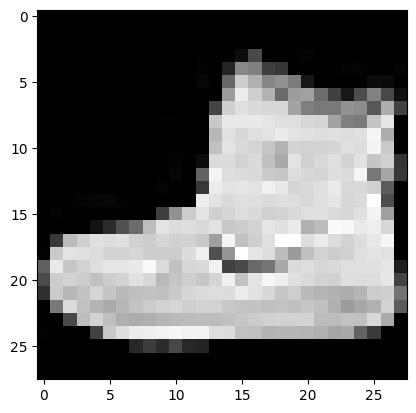

In [ ]:
# Printing an image
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

### Data loader

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([8, 1, 9, 8, 2, 7, 1, 8, 6, 5, 3, 6, 9, 8, 8, 6, 8, 0, 8, 7, 6, 7, 3, 2,
        6, 7, 6, 7, 7, 5, 7, 6, 8, 1, 0, 0, 3, 2, 5, 7, 8, 4, 7, 9, 6, 0, 8, 6,
        0, 4, 0, 6, 9, 5, 4, 4, 7, 7, 1, 6, 3, 2, 0, 2, 5, 0, 7, 1, 4, 3, 7, 0,
        9, 3, 0, 3, 9, 1, 6, 7, 8, 0, 9, 1, 1, 2, 8, 2, 4, 6, 0, 1, 3, 1, 6, 4,
        6, 5, 6, 7])


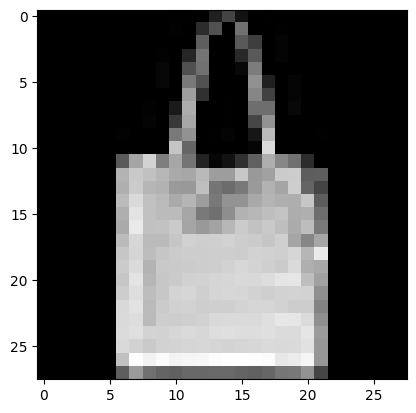

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [ ]:
# Configuring a device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

### Discriminator

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
# Discriminator layers
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
D.to(device);

### Generator

In [ ]:
latent_size = 64

In [ ]:
# Generator layers
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

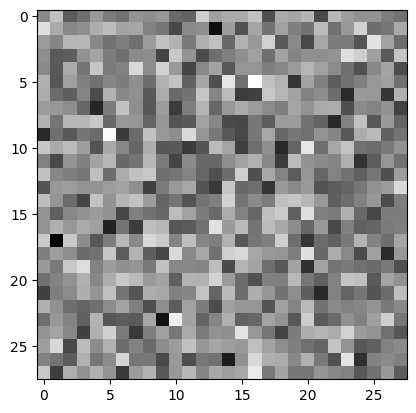

In [ ]:
plt.imshow(gen_imgs[00], cmap='gray');

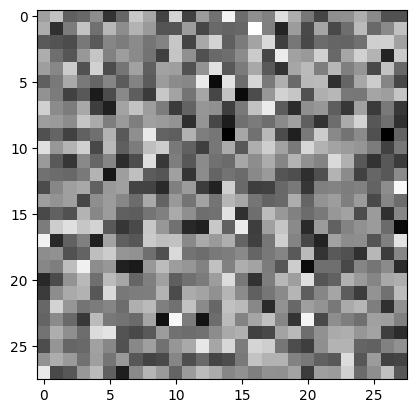

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray');

In [ ]:
G.to(device);

#### Step2. Train the GAN model to produce images in this new domain.




### Discriminator Training

In [ ]:
# Training the discriminator
# For LSGan I am using MSE loss
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Labels for the images
def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

## Loss for real and fake images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

## Combining the losses
    d_loss = d_loss_real + d_loss_fake

## Computation of Gradients
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_score, fake_score

### Generator Training

In [ ]:
## Optimizer
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
## Computing loss
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

### Training the Model

In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

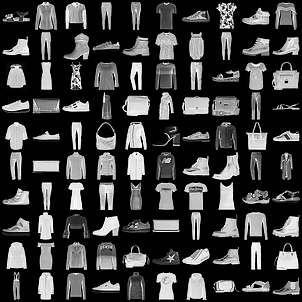

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


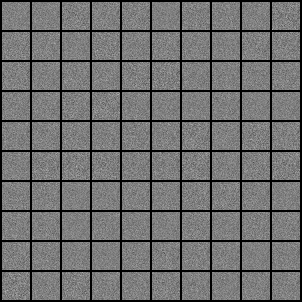

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.0700, g_loss: 0.6922, D(x): 0.94, D(G(z)): 0.25
Epoch [0/100], Step [400/600], d_loss: 0.0972, g_loss: 0.8938, D(x): 0.88, D(G(z)): 0.03
Epoch [0/100], Step [600/600], d_loss: 0.1796, g_loss: 0.6821, D(x): 0.76, D(G(z)): 0.08
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.0957, g_loss: 0.7327, D(x): 0.90, D(G(z)): 0.18
Epoch [1/100], Step [400/600], d_loss: 0.3448, g_loss: 0.6548, D(x): 0.50, D(G(z)): 0.05
Epoch [1/100], Step [600/600], d_loss: 0.2491, g_loss: 0.9575, D(x): 0.96, D(G(z)): 0.44
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.1547, g_loss: 0.6219, D(x): 0.79, D(G(z)): 0.12
Epoch [2/100], Step [400/600], d_loss: 0.1505, g_loss: 0.6891, D(x): 0.80, D(G(z)): 0.11
Epoch [2/100], Step [600/600], d_loss: 0.3484, g_loss: 0.9363, D(x): 0.96, D(G(z)): 0.54
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.2075, g_loss: 0.8224, D(x): 0.70, D(G(z)): 0.06
Epoch [3/100], Step [400/6

#### Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

#### Step4. Save the model weights in the folder to be used later.


In [ ]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G2.ckpt')
torch.save(D.state_dict(), 'D2.ckpt')

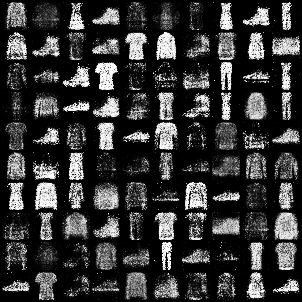

In [ ]:
Image('./samples/fake_images-0015.png')

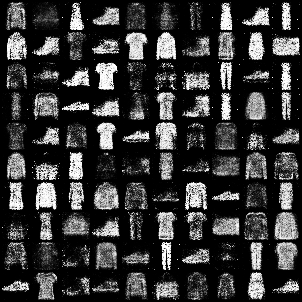

In [ ]:
Image('./samples/fake_images-0020.png')


#### Step5. Load the model using the saved weights.

#### Step 6: Re-train the GAN model to see if you can improve.

Training the Model again with different batch

In [ ]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784


# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.load_state_dict(torch.load('G2.ckpt'))  #loaded with saved weights
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.load_state_dict(torch.load('D2.ckpt'))    #loaded with saved weights
D.eval()


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [ ]:
# Training the discriminator
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
## After training the model for 300 epochs, I saved it and then re-trained it for another 200 epochs
%%time

num_epochs = 150
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Move the model to the same device as your data
D.to(device)
G.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/150], Step [200/600], d_loss: 0.2951, g_loss: 0.6972, D(x): 0.77, D(G(z)): 0.24
Epoch [0/150], Step [400/600], d_loss: 0.2764, g_loss: 0.7257, D(x): 0.76, D(G(z)): 0.24
Epoch [0/150], Step [600/600], d_loss: 0.6137, g_loss: 0.5899, D(x): 0.75, D(G(z)): 0.49
Saving fake_images-0001.png
Epoch [1/150], Step [200/600], d_loss: 0.4673, g_loss: 0.6574, D(x): 0.76, D(G(z)): 0.37
Epoch [1/150], Step [400/600], d_loss: 0.4927, g_loss: 0.4902, D(x): 0.71, D(G(z)): 0.39
Epoch [1/150], Step [600/600], d_loss: 0.4463, g_loss: 0.6407, D(x): 0.65, D(G(z)): 0.29
Saving fake_images-0002.png
Epoch [2/150], Step [200/600], d_loss: 0.5270, g_loss: 0.6366, D(x): 0.66, D(G(z)): 0.37
Epoch [2/150], Step [400/600], d_loss: 0.3573, g_loss: 0.8494, D(x): 0.74, D(G(z)): 0.24
Epoch [2/150], Step [600/600], d_loss: 0.5578, g_loss: 0.6176, D(x): 0.62, D(G(z)): 0.38
Saving fake_images-0003.png
Epoch [3/150], Step [200/600], d_loss: 0.5595, g_loss: 0.5774, D(x): 0.67, D(G(z)): 0.38
Epoch [3/150], Step [400/6

In [ ]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G3.ckpt')
torch.save(D.state_dict(), 'D3.ckpt')

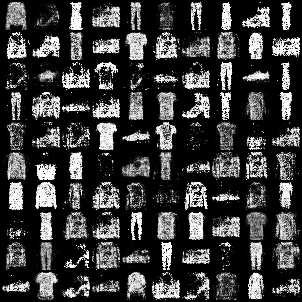

In [ ]:
Image('./samples/fake_images-0015.png')

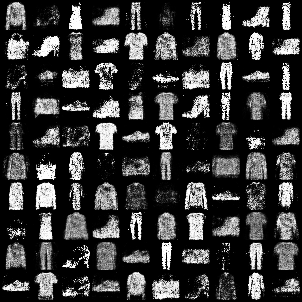

In [ ]:
Image('./samples/fake_images-0020.png')

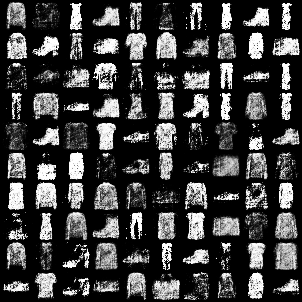

In [ ]:
Image('./samples/fake_images-0001.png')

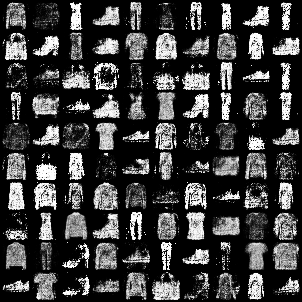

In [ ]:
Image('./samples/fake_images-0002.png')

In [ ]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784


# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.load_state_dict(torch.load('G3.ckpt'))  #loaded with saved weights
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.load_state_dict(torch.load('D3.ckpt'))    #loaded with saved weights
D.eval()

# Training the discriminator
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


In [ ]:
## After training the model for 300 epochs, I saved it and then re-trained it for another 200 epochs
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Move the model to the same device as your data
D.to(device)
G.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.3871, g_loss: 0.4738, D(x): 0.66, D(G(z)): 0.41
Epoch [0/100], Step [400/600], d_loss: 0.3713, g_loss: 0.3967, D(x): 0.72, D(G(z)): 0.40
Epoch [0/100], Step [600/600], d_loss: 0.4865, g_loss: 0.4257, D(x): 0.51, D(G(z)): 0.35
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.4869, g_loss: 0.4148, D(x): 0.65, D(G(z)): 0.50
Epoch [1/100], Step [400/600], d_loss: 0.4414, g_loss: 0.4981, D(x): 0.61, D(G(z)): 0.41
Epoch [1/100], Step [600/600], d_loss: 0.3350, g_loss: 0.5189, D(x): 0.62, D(G(z)): 0.31
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.4513, g_loss: 0.5463, D(x): 0.63, D(G(z)): 0.43
Epoch [2/100], Step [400/600], d_loss: 0.5333, g_loss: 0.3526, D(x): 0.56, D(G(z)): 0.47
Epoch [2/100], Step [600/600], d_loss: 0.1947, g_loss: 0.7015, D(x): 0.76, D(G(z)): 0.24
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.4759, g_loss: 0.4236, D(x): 0.51, D(G(z)): 0.36
Epoch [3/100], Step [400/6

In [ ]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G4.pth')
torch.save(D.state_dict(), 'D4.pth')

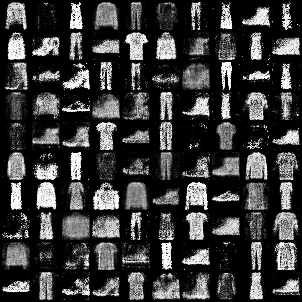

In [ ]:
Image('./samples/fake_images-0015.png')


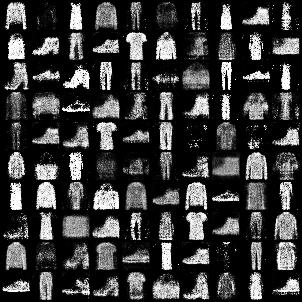

In [ ]:

Image('./samples/fake_images-0020.png')

In [ ]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784


# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.load_state_dict(torch.load('G4.pth'))  #loading the saved weights without saving the weights at checkpoint
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.load_state_dict(torch.load('D4.pth'))
D.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

Observation:
LSGan are more efficienct than GANs because the reuslts achieved by a GAN in 300 epochs was achieved by LSGan in 100 epochs. LSGans are not as much time consuming as GANs.

https://github.com/sweekruthi-balivada/Deep-Learning